In [194]:
# O zoo fornece recurso para series temporais
library(zoo)

# dataframe de alto desempenho do R
library(data.table)

# forçar o fundo branco
library(ggplot2)

#### Limpeza dos dados

* dados ausentes
* upsamping e dowsampling
* suavização dos dados
* lidar com sazonalidade dos dados
* prevenir lookaheads não intencionais

Dados ausente em series temporais são bem comuns pois a carga longitudinal é bastante pesada, para lidar com isso se tem alguns metodos:
1. `Imputing`
2. `interpolação`: usa pontos vizinhos para lidar com valores ausentes
3. `Exclusão de dados`

In [195]:

path_ = "C:\\Users\\mateu\\Documents\\MEGA\\Projetos-git\\analise-pratica-series-temporais_predicao-stats-ml\\capitulo-2-encontrando-dados-e-usando-data-wrangling-com-st\\dataset\\gov\\UNRATE.csv"
# Lendo arquivo 
unemp = fread(input = path_ )

In [196]:
head(unemp, n=5)

DATE,UNRATE
<IDate>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [197]:
# convertendo para tipo data
unemp[, DATE:=as.Date(DATE)]

setkey(unemp, DATE)

In [198]:
head(x=unemp, n=5)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [199]:
## Gera um conj. de dados onde os dados estão aleatoriamente
### ausentes
rand.unemp.idx = sample(
    1:nrow(unemp), .1*nrow(unemp)
)
rand.unemp.idx

[1] 174 192 257 793 795 101 784 129 641 123 827 733   7 318 298 253 497 606 498
[20] 541 677 220 375  72 282 526  89  61 758 342  97 410 557 301 437 642  29  62
[39]  39 379 745 761 288 268 530 654 616 223 224 314 740 730 102 315 676  88 652
[58] 709 348 116 586 769 352 294 366 461 796 164 473 185 293 646 415 810 841 479
[77] 172 746  65 757 595 690  58 509

In [200]:
rand.unemp = unemp[-rand.unemp.idx]
head(rand.unemp, n=10)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-08-01,3.9
1948-09-01,3.8
1948-10-01,3.7


In [201]:
## Gera um conj. de dados onde os dados possuem maior
### probalidade de ausencia quando o desemprego é alto

alto.unemp.idx = which(unemp$UNRATE>8)
num.to.select  = .2*length(alto.unemp.idx)

alto.unemp.idx = sample(alto.unemp.idx, )

bias.unemp = unemp[-alto.unemp.idx]

In [202]:
which(bias.unemp$UNRATE>8)

integer(0)

Usando rolling join para ler valores ausentes

In [203]:
all.dates = seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1), by='months')

In [204]:
rand.unemp = rand.unemp[J(all.dates), on='DATE', roll=0]
bias.unemp = rand.unemp[J(all.dates), on='DATE', roll=0]

In [205]:
rand.unemp[, rpt := is.na(UNRATE)]

In [206]:
head(rand.unemp[rand.unemp$rpt==TRUE], 2)

DATE,UNRATE,rpt
<date>,<dbl>,<lgl>
1948-07-01,NA,TRUE
1950-05-01,NA,TRUE


#### Trando dados ausentes
**forward fill**: preenche valores ausente com base no valor anterior a ele que não é ausente

In [207]:
# Forward fill
rand.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]
bias.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]

NULL

NULL

NULL

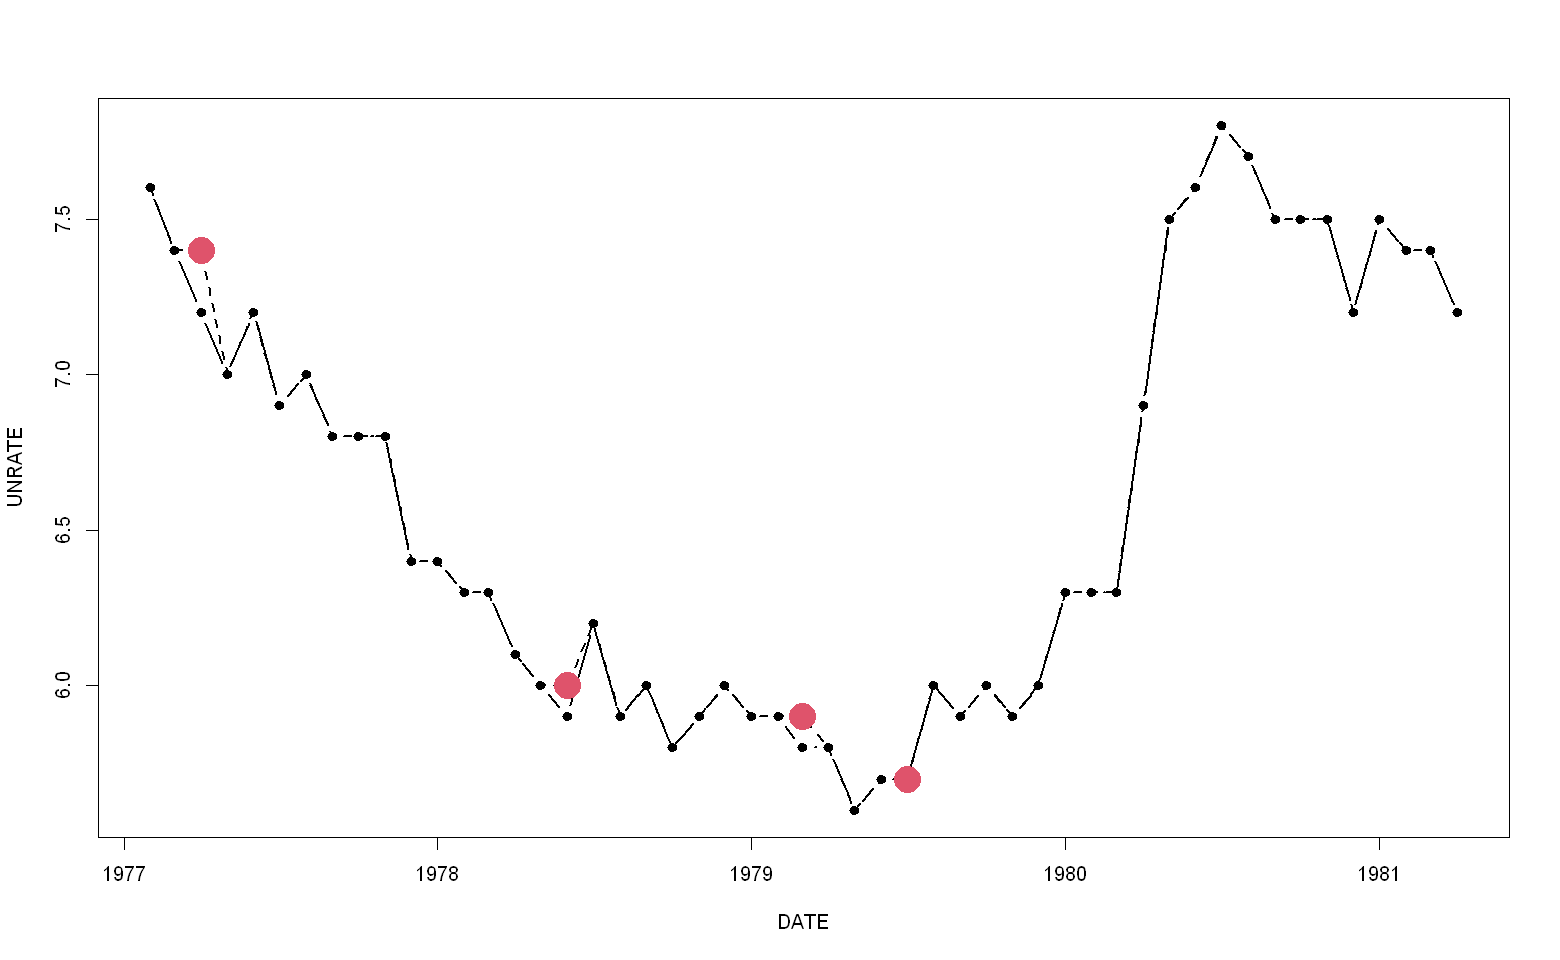

In [208]:
par(bg='white')
options(repr.plot.width = 13, repr.plot.height = 8)
unemp[350:400, plot(
    DATE, UNRATE, col=1, lwd=2, type='b', pch=19
)]
rand.unemp[
    350:400, lines(
    DATE, impute.ff, col=1, lwd=2, lty=2
)
]
rand.unemp[350:400][rpt==TRUE, 
    points(DATE, impute.ff, col=2, pch=19, cex=3)
]

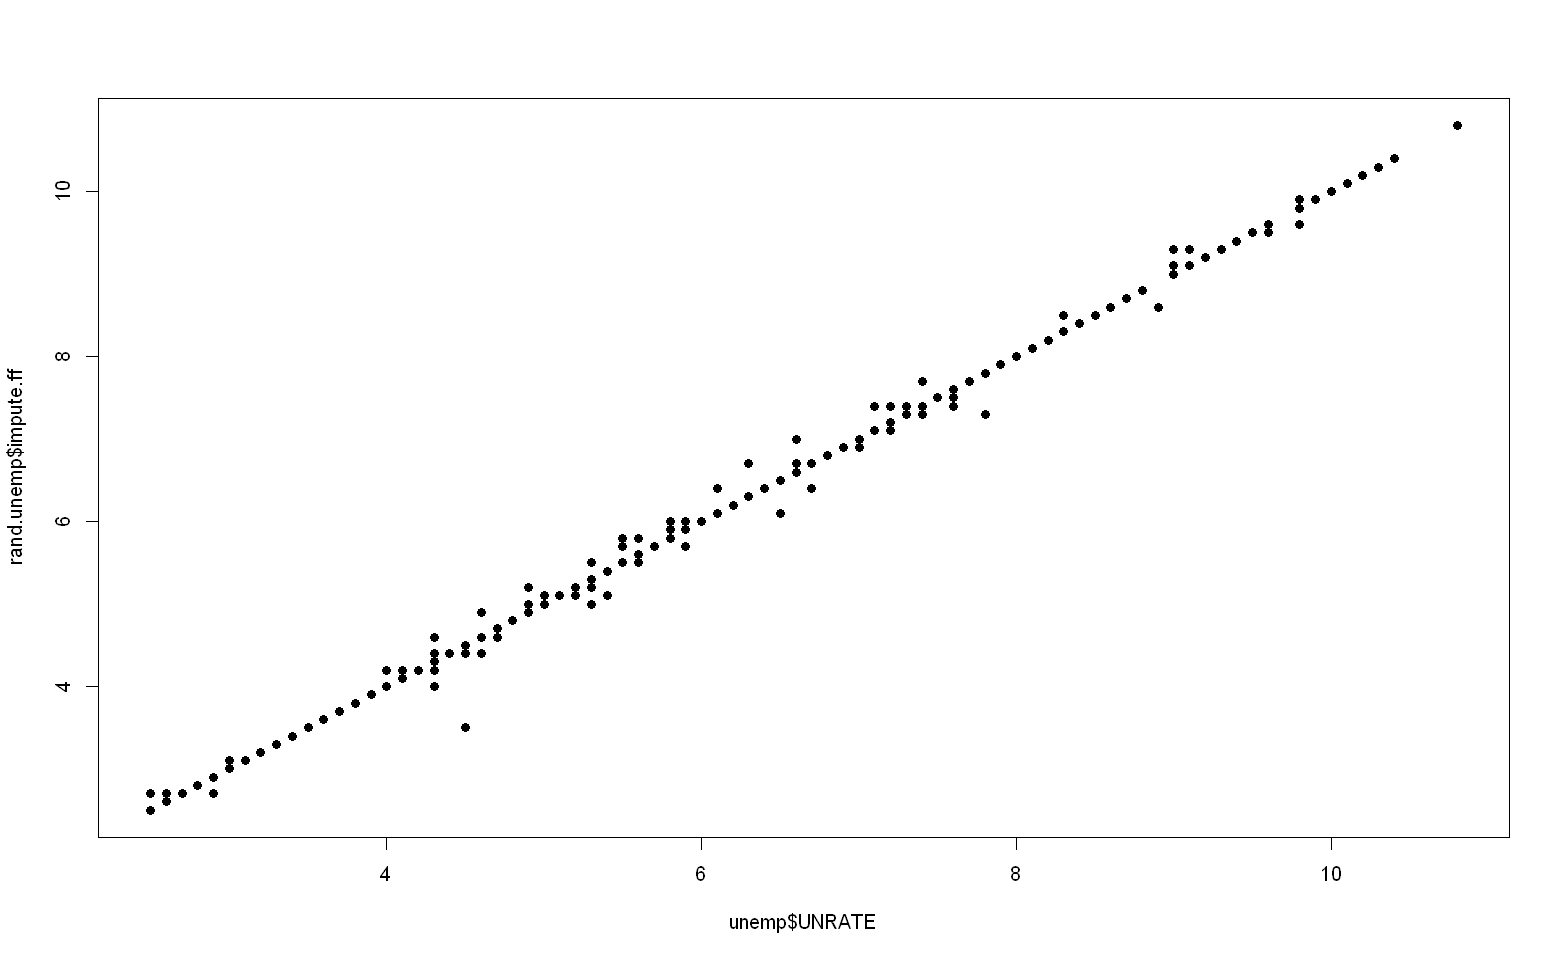

In [209]:
par(bg = 'white')
plot(unemp$UNRATE, rand.unemp$impute.ff, pch=19)

**Média movel :** Semelhante ao forward fill mas usa a media e mediana para imputar valores ausentes

In [210]:
rand.unemp[,
    impute.rm.naolookahead := rollapply(c(NA, NA, UNRATE) ,3 ,
    function(x){
        if(!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    })
]

In [211]:
head(rand.unemp, n=2)

DATE,UNRATE,rpt,impute.ff,impute.rm.naolookahead
<date>,<dbl>,<lgl>,<dbl>,<dbl>
1948-01-01,3.4,FALSE,3.4,3.4
1948-02-01,3.8,FALSE,3.8,3.8


In [212]:
bias.unemp[,
    impute.rm.naolookahead := rollapply(c(NA, NA, UNRATE) ,3 ,
    function(x){
        if(!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    })
]

fazem a imputacao com a media movel com dados antes e depois

exemplors de rollapply

In [213]:
a = c(NA, NA, NA, 4, 4, 5, NA)

In [214]:
rollapply(c(NA, a, NA , NA, NA) ,5 ,
    function(x){
        if(!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
    })

[1] 4.000000 4.000000 4.333333 4.000000 4.000000 5.000000 5.000000

**interpolação**

In [215]:
# Iterpolaçao linear
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

In [216]:
# Polinomial
rand.unemp[, impute.sp := na.spline(UNRATE)]
bias.unemp[, impute.sp := na.spline(UNRATE)]

In [217]:
use.idx = 90:120

NULL

NULL

NULL

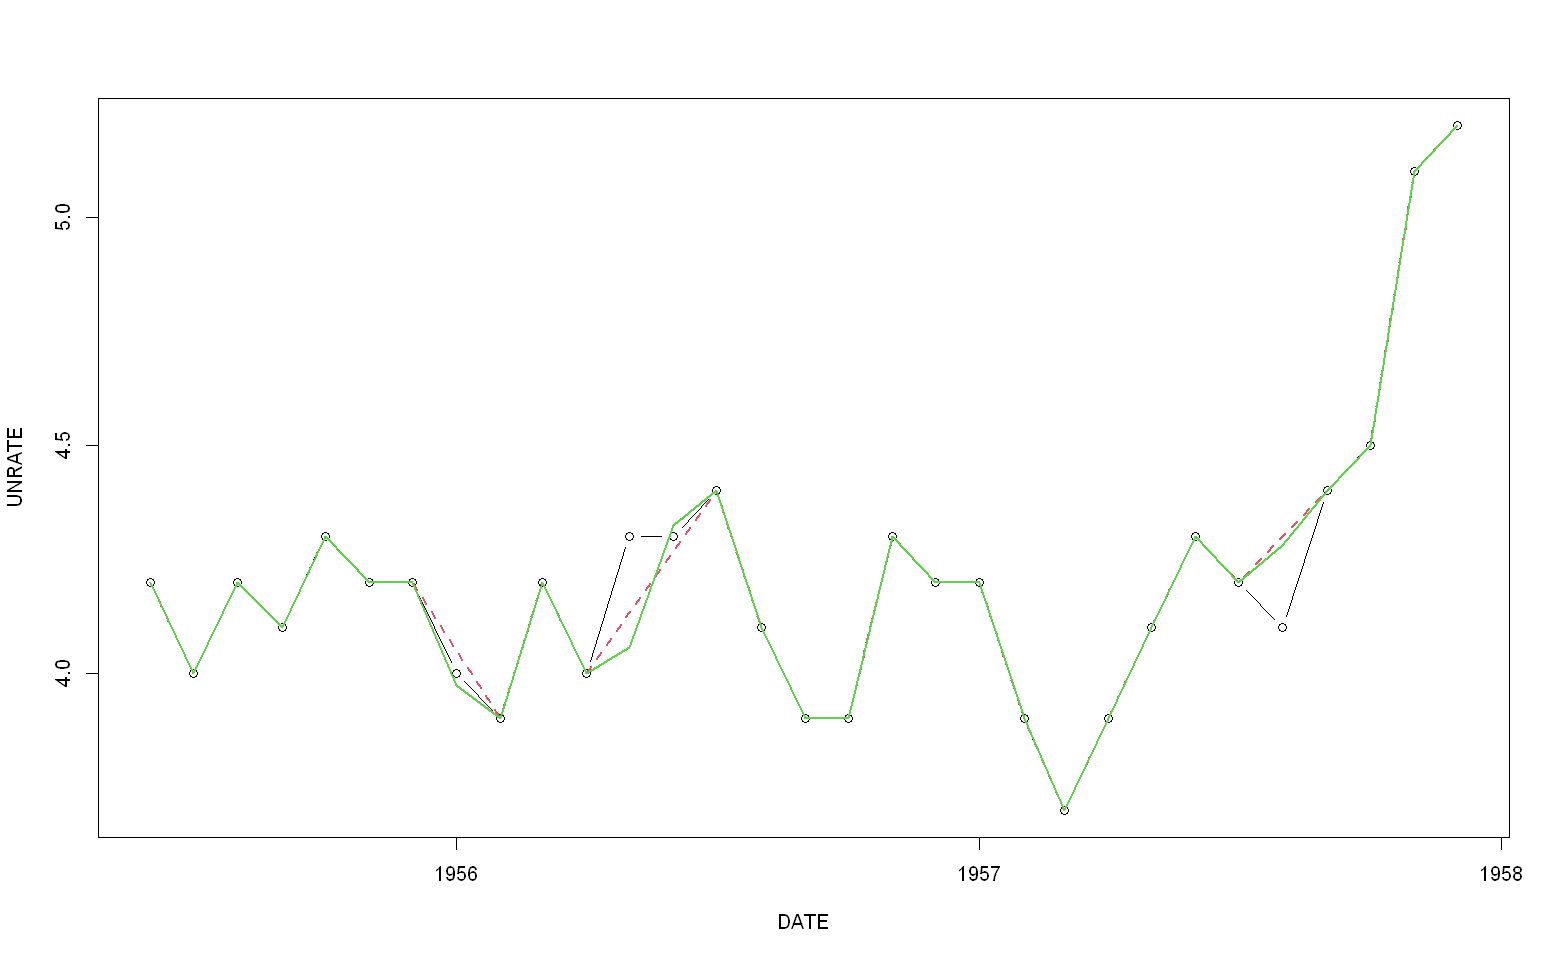

In [218]:
par(bg='white')
options(repr.plot.width = 13, repr.plot.height = 8)
unemp[use.idx, plot(
    DATE, UNRATE, col=1, type='b'
)]
rand.unemp[
    use.idx, lines(
    DATE, impute.li, col=2, lwd=2, lty=2
)
]
rand.unemp[use.idx, 
    lines(DATE, impute.sp, col=3, pch=19, cex=3, lwd=2)
]

In [228]:
# Calcular o erro médio quadrático para as colunas especificadas
errors <- rand.unemp[, lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)), .SDcols = c("impute.ff", "impute.rm.naolookahead", "impute.li", "impute.sp")]

# Transformar a lista em vetor
errors_vector <- unlist(errors)

# Ordenar os erros
sorted_errors <- sort(errors_vector)
print(sorted_errors)


             impute.li              impute.sp              impute.ff 
           0.001324381            0.001932225            0.004644550 
impute.rm.naolookahead 
           0.006676540 


In [230]:
# Calcular o erro médio quadrático para as colunas especificadas
errors < bias.unemp[, lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)), .SDcols = c("impute.ff", "impute.rm.naolookahead", "impute.li", "impute.sp")]

# Transformar a lista em vetor
errors_vector <- unlist(errors)

# Ordenar os erros
sorted_errors <- sort(errors_vector)
print(sorted_errors)


impute.ff,impute.rm.naolookahead,impute.li,impute.sp
FALSE,FALSE,FALSE,FALSE


             impute.li              impute.sp              impute.ff 
           0.001324381            0.001932225            0.004644550 
impute.rm.naolookahead 
           0.006676540 
